In [87]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

In [88]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [89]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [90]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


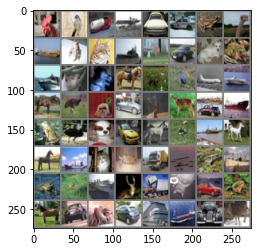

bird  bird  truck plane car   car   frog  bird  ship  frog  cat   ship  deer  car   dog   frog  ship  cat   dog   horse cat   bird  plane ship  horse bird  dog   car   deer  deer  car   ship  frog  bird  dog   car   horse bird  ship  horse horse ship  cat   cat   truck plane frog  ship  frog  deer  ship  deer  truck cat   car   frog  horse car   cat   car   ship  ship  car   deer 


In [91]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [92]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [93]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.005,momentum = 0.9):
    history = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [94]:
begin = time.time()
history, end = fit(15, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

  0%|          | 0/657 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 657/657 [00:09<00:00, 65.96it/s]


Epoch [0], Time taken :11.6590, train_loss : 1.9256, train_acc: 0.2940, val_loss: 1.6559, val_acc: 0.4009


100%|██████████| 657/657 [00:10<00:00, 62.75it/s]


Epoch [1], Time taken :12.3541, train_loss : 1.5204, train_acc: 0.4424, val_loss: 1.4449, val_acc: 0.4793


100%|██████████| 657/657 [00:10<00:00, 65.47it/s]


Epoch [2], Time taken :11.7865, train_loss : 1.3427, train_acc: 0.5125, val_loss: 1.2984, val_acc: 0.5268


100%|██████████| 657/657 [00:09<00:00, 66.41it/s]


Epoch [3], Time taken :11.7375, train_loss : 1.2163, train_acc: 0.5669, val_loss: 1.2009, val_acc: 0.5705


100%|██████████| 657/657 [00:11<00:00, 59.04it/s]


Epoch [4], Time taken :12.8947, train_loss : 1.1240, train_acc: 0.6040, val_loss: 1.1360, val_acc: 0.6008


100%|██████████| 657/657 [00:09<00:00, 65.93it/s]


Epoch [5], Time taken :11.7589, train_loss : 1.0582, train_acc: 0.6302, val_loss: 1.1114, val_acc: 0.6085


100%|██████████| 657/657 [00:10<00:00, 65.32it/s]


Epoch [6], Time taken :11.9152, train_loss : 1.0068, train_acc: 0.6490, val_loss: 1.1218, val_acc: 0.6175


100%|██████████| 657/657 [00:10<00:00, 63.82it/s]


Epoch [7], Time taken :12.5392, train_loss : 0.9535, train_acc: 0.6689, val_loss: 1.1099, val_acc: 0.6129


100%|██████████| 657/657 [00:10<00:00, 63.49it/s]


Epoch [8], Time taken :12.1907, train_loss : 0.9269, train_acc: 0.6775, val_loss: 1.0388, val_acc: 0.6447


100%|██████████| 657/657 [00:10<00:00, 60.50it/s]


Epoch [9], Time taken :12.8593, train_loss : 0.8848, train_acc: 0.6944, val_loss: 1.0023, val_acc: 0.6579


100%|██████████| 657/657 [00:10<00:00, 64.07it/s]


Epoch [10], Time taken :12.0804, train_loss : 0.8557, train_acc: 0.7050, val_loss: 0.9974, val_acc: 0.6585


100%|██████████| 657/657 [00:09<00:00, 66.22it/s]


Epoch [11], Time taken :11.7201, train_loss : 0.8294, train_acc: 0.7147, val_loss: 1.0108, val_acc: 0.6611


100%|██████████| 657/657 [00:10<00:00, 62.08it/s]


Epoch [12], Time taken :12.3206, train_loss : 0.7990, train_acc: 0.7251, val_loss: 0.9927, val_acc: 0.6649


100%|██████████| 657/657 [00:10<00:00, 64.75it/s]


Epoch [13], Time taken :11.9334, train_loss : 0.7804, train_acc: 0.7335, val_loss: 1.0101, val_acc: 0.6620


100%|██████████| 657/657 [00:10<00:00, 65.15it/s]


Epoch [14], Time taken :11.9416, train_loss : 0.7573, train_acc: 0.7398, val_loss: 0.9963, val_acc: 0.6674
Finished Training in 181.92000651359558secs


In [95]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

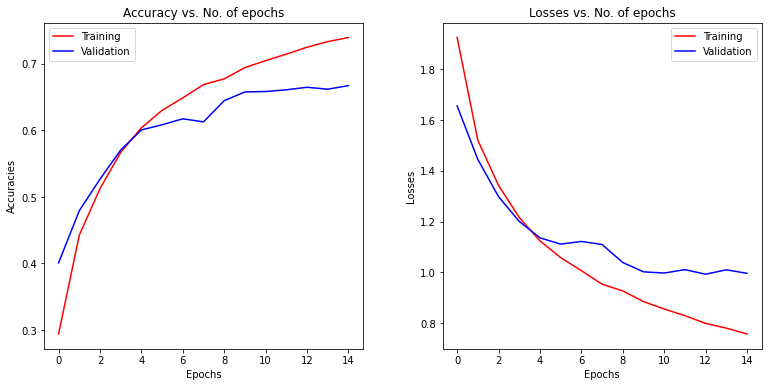

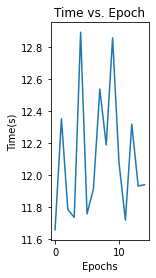

In [96]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(1,3,3)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
              
plot_results(history)

In [97]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [98]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 66 %


In [99]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.1 %
Accuracy for class: car   is 78.0 %
Accuracy for class: bird  is 50.7 %
Accuracy for class: cat   is 43.7 %
Accuracy for class: deer  is 70.5 %
Accuracy for class: dog   is 59.9 %
Accuracy for class: frog  is 78.6 %
Accuracy for class: horse is 67.9 %
Accuracy for class: ship  is 82.1 %
Accuracy for class: truck is 75.9 %
